#ENG Bi-LSTM BASED 목차
## 데이터 이해 및 전처리 과정
>1. 데이터 로드 및 필요한 라이브러리 호출
>2. 데이터 정제하기
>3. 토큰화
>4. 인코딩
>5. 패딩 작업
## Bi-LSTM을 베이스로 한 모델 구축
>1. 베스트모델 학습
>2. 모델에 예시 적용 및 예측

**데이터 이해 및 전처리 과정**

In [1]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 73.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.6/465.6 KB 49.2 MB/s eta 0:00:00


In [2]:
# DATA_TYPE = "anonym"
# LANGUAGE = "ko"

In [3]:
DATA_TYPE = "translation"
LANGUAGE = "en"

1. 데이터 로드 및 필요한 라이브러리 호출

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [5]:
total_data = pd.read_csv("/content/dataset_10116_34477.csv")  #데이터 파일 불러오기

In [6]:
#total_data[:5] #상위 데이터 확인

2. 데이터 정제하기

In [7]:
RANDOM_STATE = 42

In [8]:
X = total_data
y = total_data['label']

# Split total_data
# Train : Test = 8 : 2
train_data, test_data, y_train, y_test=train_test_split(X, y, 
                                                        test_size=0.2, 
                                                        shuffle=True,
                                                        stratify=y,
                                                        random_state=RANDOM_STATE)

train_data = train_data.reset_index()
# valid_data = valid_data.reset_index()
test_data  = test_data.reset_index()

y_train = y_train.reset_index()['label']
# y_valid = y_valid.reset_index()['label']
y_test  = y_test.reset_index()['label']

print(f'--- Rate of Falls in Train Datasets (N = {len(y_train)}) ---')
print(f'Non-Fall Data (label : 0) = {y_train.value_counts()[0]} ({round(y_train.value_counts()[0]/len(y_train) * 100,3)})%')
print(f'    Fall Data (label : 1) = {y_train.value_counts()[1]} ({round(y_train.value_counts()[1]/len(y_train) * 100,3)})%')
print()
# print(f'--- Rate of Falls in Validation Datasets (N = {len(y_valid)}) ---')
# print(f'Non-Fall Data (label : 0) = {y_valid.value_counts()[0]} ({round(y_valid.value_counts()[0]/len(y_valid) * 100,3)})%')
# print(f'    Fall Data (label : 1) = {y_valid.value_counts()[1]} ({round(y_valid.value_counts()[1]/len(y_valid) * 100,3)})%')
print()
print(f'--- Rate of Falls in Test Datasets (N = {len(y_test)}) ---')
print(f'Non-Fall Data (label : 0) = {y_test.value_counts()[0]} ({round(y_test.value_counts()[0]/len(y_test) * 100,3)})%')
print(f'    Fall Data (label : 1) = {y_test.value_counts()[1]} ({round(y_test.value_counts()[1]/len(y_test) * 100,3)})%')

--- Rate of Falls in Train Datasets (N = 27581) ---
Non-Fall Data (label : 0) = 19488 (70.657)%
    Fall Data (label : 1) = 8093 (29.343)%


--- Rate of Falls in Test Datasets (N = 6896) ---
Non-Fall Data (label : 0) = 4873 (70.664)%
    Fall Data (label : 1) = 2023 (29.336)%


In [9]:
print('훈련용 데이터 개수 :', len(train_data)) # 훈련용 데이터 개수 출력

훈련용 데이터 개수 : 27581


In [10]:
print('테스트용 데이터 개수 :',len(test_data)) # 테스트용 데이터 개수 출력

테스트용 데이터 개수 : 6896


In [11]:
#train_data[:5]

In [12]:
train_data['anonym'].nunique(), train_data['label'].nunique()
# anonym 열, label 열의 중복을 제외한 값의 개수 

(26045, 2)

In [13]:
train_data.drop_duplicates(subset=['anonym'], inplace=True)
#앞선 27581개와와 차이가 난 만큼 중복제거

In [14]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 26045


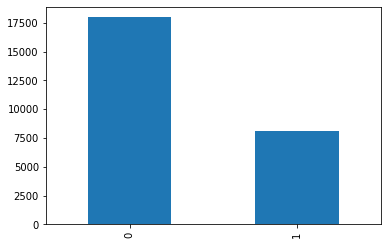

In [15]:
train_data['label'].value_counts().plot(kind = 'bar') #낙상사고 비율 확인

In [16]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  17965
1      1   8080


In [17]:
print(train_data.isnull().values.any()) #null 값이 있는 지 한번 더 확인인

False


In [18]:
print(train_data.isnull().sum()) #2번째 확인인

index             0
HOSPITAL          0
label             0
note              0
anonym            0
translation       0
#ProcessedData    0
#TokenizedData    0
dtype: int64


In [19]:
train_data.loc[train_data.anonym.isnull()] #3번째 확인인

,index,HOSPITAL,label,note,anonym,translation,#ProcessedData,#TokenizedData


In [20]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [21]:
#영어와 공백을 제외하고 모두 제거
#train_data['anonym'] = train_data['anonym'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
#train_data[:5]

In [22]:
train_data['anonym'] = train_data['anonym'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['anonym'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

index             0
HOSPITAL          0
label             0
note              0
anonym            0
translation       0
#ProcessedData    0
#TokenizedData    0
dtype: int64


<ipython-input-22-310879df2702>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['anonym'] = train_data['anonym'].str.replace('^ +', "") # white space 데이터를 empty value로 변경


3.토큰화

In [23]:
stopwords = [] #영어에는 불용어가 딱히 없다.

In [24]:
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [25]:
X_train = []
for sentence in tqdm(train_data['anonym']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 26045/26045 [02:30<00:00, 173.04it/s]


In [26]:
#print(X_train[:3])


In [27]:
X_test = []
for sentence in tqdm(test_data['anonym']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 6896/6896 [00:40<00:00, 168.37it/s]


4.인코딩

In [28]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train) #각 단어에 고유한 정수 부여여

In [29]:
#print(tokenizer.word_index)
#가장 많이 나오는 단어들부터 작은 숫자가 매겨짐짐

In [30]:
tokenizer = Tokenizer() 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test) 
#케라스 토크나이저의 인자로 넘겨주고 텍스트 시퀀스를 정수 시퀀스로 변환합니다.

In [31]:
print(X_train[:3]) #각 샘플 내의 단어들은 각 단어에 대한 정수로 변환된 것을 확인

[[38, 220, 3, 22, 12, 132, 187, 35, 826, 3149, 233, 87, 1, 12], [89, 501, 904, 619, 48, 4, 158, 208, 52, 4, 1191, 8, 2, 1, 224, 92, 149, 48, 4, 40, 208, 52, 4, 1796, 8, 183, 1, 52, 264, 425, 221, 94, 37, 182, 1, 48, 501, 425, 221, 109, 503, 3, 14, 321, 1, 89, 288, 1, 392, 195, 294, 48, 4, 40, 208, 52, 4, 121, 32, 48, 4, 40, 208, 52, 4, 121, 32, 3, 92, 149, 4, 1341, 8, 183, 1, 89, 136, 455, 221, 13, 1, 155, 191, 214, 23, 6, 27, 29, 2, 1, 495, 5, 1137, 3354, 128, 7, 94, 328, 1, 65, 15, 3476, 413, 1455, 3, 20, 674, 11, 134, 1, 2344, 2038, 14, 1, 20, 674, 11, 134, 1], [1323, 44, 477, 7, 188, 38, 84, 90, 26, 15, 393, 13, 1, 9, 96, 106, 1, 163, 23, 186, 5, 601, 6484, 2192, 17, 6, 51, 47, 24, 75, 61, 10027, 6, 97, 5, 82, 318, 3, 33, 2]]


In [32]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])


5. 패딩작업

데이터의 최대 길이 : 513
데이터터의 평균 길이 : 54.350854290650794


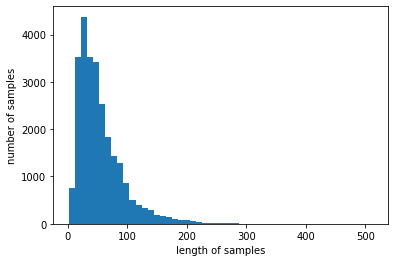

In [33]:
print('데이터의 최대 길이 :',max(len(review) for review in X_train))
print('데이터터의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()
#서로다른 길이를 맞추기 위해 패딩작업 진행 120이하로 구성.가장 많은 구성은 약 25정도.

서로 다른 길이 샘플들의 길이를 패딩작업 시작.


290이하의 길이가 전체적으로 분포 되어있으며 max는 513 M은 54


In [34]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [35]:
max_len = 230
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 230 이하인 샘플의 비율: 99.56229602610865


훈련용 데이터 99.56이 230이하의 길이를 가지므로 훈련용 데이터를 길이 230으로 패딩합니다.


In [36]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [37]:
vocab_size = len(tokenizer.word_index) + 1

---
**Bi-LSTM을 베이스로 한 모델 구축**

In [38]:
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding( vocab_size , embedding_dim))
model.add(Bidirectional(LSTM(hidden_units))) # Bidirectional LSTM을 사용
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.compile(optimizer='rmsprop', loss='binary_crossentropy', 
              metrics=[tf.keras.metrics.Precision(name='precision'),
                      tf.keras.metrics.Recall(name='recall'),
                      tf.keras.metrics.FalsePositives(name='false_positives'),
                      tf.keras.metrics.FalseNegatives(name='false_negatives'),
                      'accuracy'],
              )
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=256, validation_split=0.2)

Epoch 1/15
82/82 [==============================] - ETA: 0s - loss: 0.2413 - precision: 0.9313 - recall: 0.7406 - false_positives: 353.0000 - false_negatives: 1676.0000 - accuracy: 0.9026

82/82 [==============================] - 18s 80ms/step - loss: 0.2413 - precision: 0.9313 - recall: 0.7406 - false_positives: 353.0000 - false_negatives: 1676.0000 - accuracy: 0.9026 - val_loss: 0.1003 - val_precision: 0.9596 - val_recall: 0.9389 - val_false_positives: 64.0000 - val_false_negatives: 99.0000 - val_accuracy: 0.9687
Epoch 2/15
82/82 [==============================] - ETA: 0s - loss: 0.0561 - precision: 0.9690 - recall: 0.9780 - false_positives: 202.0000 - false_negatives: 142.0000 - accuracy: 0.9835

82/82 [==============================] - 4s 50ms/step - loss: 0.0561 - precision: 0.9690 - recall: 0.9780 - false_positives: 202.0000 - false_negatives: 142.0000 - accuracy: 0.9835 - val_loss: 0.0475 - val_precision: 0.9737 - val_recall: 0.9821 - val_false_positives: 43.0000 - val_false_negatives: 29.0000 - val_accuracy: 0.9862
Epoch 3/15
82/82 [==============================] - ETA: 0s - loss: 0.0384 - precision: 0.9802 - recall: 0.9861 - false_positives: 129.0000 - false_negatives: 90.0000 - accuracy: 0.9895

82/82 [==============================] - 4s 52ms/step - loss: 0.0384 - precision: 0.9802 - recall: 0.9861 - false_positives: 129.0000 - false_negatives: 90.0000 - accuracy: 0.9895 - val_loss: 0.0608 - val_precision: 0.9601 - val_recall: 0.9796 - val_false_positives: 66.0000 - val_false_negatives: 33.0000 - val_accuracy: 0.9810
Epoch 4/15
82/82 [==============================] - ETA: 0s - loss: 0.0326 - precision: 0.9851 - recall: 0.9858 - false_positives: 96.0000 - false_negatives: 92.0000 - accuracy: 0.9910

82/82 [==============================] - 4s 49ms/step - loss: 0.0326 - precision: 0.9851 - recall: 0.9858 - false_positives: 96.0000 - false_negatives: 92.0000 - accuracy: 0.9910 - val_loss: 0.0464 - val_precision: 0.9702 - val_recall: 0.9846 - val_false_positives: 49.0000 - val_false_negatives: 25.0000 - val_accuracy: 0.9858
Epoch 5/15
82/82 [==============================] - ETA: 0s - loss: 0.0281 - precision: 0.9869 - recall: 0.9906 - false_positives: 85.0000 - false_negatives: 61.0000 - accuracy: 0.9930

82/82 [==============================] - 4s 49ms/step - loss: 0.0281 - precision: 0.9869 - recall: 0.9906 - false_positives: 85.0000 - false_negatives: 61.0000 - accuracy: 0.9930 - val_loss: 0.0474 - val_precision: 0.9668 - val_recall: 0.9895 - val_false_positives: 55.0000 - val_false_negatives: 17.0000 - val_accuracy: 0.9862
Epoch 6/15
81/82 [============================>.] - ETA: 0s - loss: 0.0227 - precision: 0.9887 - recall: 0.9924 - false_positives: 73.0000 - false_negatives: 49.0000 - accuracy: 0.9941

82/82 [==============================] - 4s 49ms/step - loss: 0.0226 - precision: 0.9887 - recall: 0.9924 - false_positives: 73.0000 - false_negatives: 49.0000 - accuracy: 0.9941 - val_loss: 0.0525 - val_precision: 0.9829 - val_recall: 0.9556 - val_false_positives: 27.0000 - val_false_negatives: 72.0000 - val_accuracy: 0.9810
Epoch 7/15
82/82 [==============================] - ETA: 0s - loss: 0.0184 - precision: 0.9912 - recall: 0.9930 - false_positives: 57.0000 - false_negatives: 45.0000 - accuracy: 0.9951

82/82 [==============================] - 4s 50ms/step - loss: 0.0184 - precision: 0.9912 - recall: 0.9930 - false_positives: 57.0000 - false_negatives: 45.0000 - accuracy: 0.9951 - val_loss: 0.0471 - val_precision: 0.9767 - val_recall: 0.9815 - val_false_positives: 38.0000 - val_false_negatives: 30.0000 - val_accuracy: 0.9869
Epoch 8/15
82/82 [==============================] - ETA: 0s - loss: 0.0170 - precision: 0.9906 - recall: 0.9941 - false_positives: 61.0000 - false_negatives: 38.0000 - accuracy: 0.9952

82/82 [==============================] - 4s 50ms/step - loss: 0.0170 - precision: 0.9906 - recall: 0.9941 - false_positives: 61.0000 - false_negatives: 38.0000 - accuracy: 0.9952 - val_loss: 0.0423 - val_precision: 0.9737 - val_recall: 0.9827 - val_false_positives: 43.0000 - val_false_negatives: 28.0000 - val_accuracy: 0.9864
Epoch 9/15
81/82 [============================>.] - ETA: 0s - loss: 0.0143 - precision: 0.9930 - recall: 0.9956 - false_positives: 45.0000 - false_negatives: 28.0000 - accuracy: 0.9965

82/82 [==============================] - 4s 52ms/step - loss: 0.0143 - precision: 0.9931 - recall: 0.9957 - false_positives: 45.0000 - false_negatives: 28.0000 - accuracy: 0.9965 - val_loss: 0.0581 - val_precision: 0.9605 - val_recall: 0.9901 - val_false_positives: 66.0000 - val_false_negatives: 16.0000 - val_accuracy: 0.9843
Epoch 10/15
82/82 [==============================] - ETA: 0s - loss: 0.0116 - precision: 0.9947 - recall: 0.9958 - false_positives: 34.0000 - false_negatives: 27.0000 - accuracy: 0.9971

82/82 [==============================] - 4s 50ms/step - loss: 0.0116 - precision: 0.9947 - recall: 0.9958 - false_positives: 34.0000 - false_negatives: 27.0000 - accuracy: 0.9971 - val_loss: 0.0552 - val_precision: 0.9777 - val_recall: 0.9759 - val_false_positives: 36.0000 - val_false_negatives: 39.0000 - val_accuracy: 0.9856
Epoch 11/15
82/82 [==============================] - ETA: 0s - loss: 0.0098 - precision: 0.9950 - recall: 0.9955 - false_positives: 32.0000 - false_negatives: 29.0000 - accuracy: 0.9971

82/82 [==============================] - 4s 50ms/step - loss: 0.0098 - precision: 0.9950 - recall: 0.9955 - false_positives: 32.0000 - false_negatives: 29.0000 - accuracy: 0.9971 - val_loss: 0.0733 - val_precision: 0.9812 - val_recall: 0.9667 - val_false_positives: 30.0000 - val_false_negatives: 54.0000 - val_accuracy: 0.9839
Epoch 12/15
81/82 [============================>.] - ETA: 0s - loss: 0.0080 - precision: 0.9972 - recall: 0.9961 - false_positives: 18.0000 - false_negatives: 25.0000 - accuracy: 0.9979

82/82 [==============================] - 4s 50ms/step - loss: 0.0083 - precision: 0.9971 - recall: 0.9961 - false_positives: 19.0000 - false_negatives: 25.0000 - accuracy: 0.9979 - val_loss: 0.0511 - val_precision: 0.9690 - val_recall: 0.9840 - val_false_positives: 51.0000 - val_false_negatives: 26.0000 - val_accuracy: 0.9852
Epoch 12: early stopping


In [39]:
model.save("my_model.h5")
#케라스형식 모델 저장 (bestmodel.h5에 자동 저장이 안되기 때문에에)

In [40]:
loaded_model = load_model('my_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

216/216 [==============================] - 4s 12ms/step - loss: 0.0496 - precision: 0.9707 - recall: 0.9832 - false_positives: 60.0000 - false_negatives: 34.0000 - accuracy: 0.9864

 테스트 정확도: 0.9707


In [41]:
def fall_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 낙상사고입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 낙상사고가 아닙니다.\n".format((1 - score) * 100))
#(기본 구성이자 흐름)

In [42]:
fall_predict('와 이거 실화냐? 진짜 가슴이 웅장해진다 내가 생각했던 그 나투로와 사스케가 맞냐? 정말 세계관 최강자들의 싸움이다')

1/1 [==============================] - 2s 2s/step
99.00% 확률로 낙상사고가 아닙니다.



In [43]:
fall_predict('병실에 보호자(아들) 있었으나 수면 중이었으며 올려져 있는 side rail사이의 54cm(발치 쪽)사이로 내려오다가  왼쪽 옆구리를 부딪힌 후 환자  움직이는 소리에 잠에서 깨어난 보호자와 함께 화장실 다녀 왔다함. 낙상 시 side rail에  Lt. flank 부딪혀 통증 있어 X-ray 촬영 후 협진 본 후 진통제 처방 남.')


1/1 [==============================] - 0s 28ms/step
99.93% 확률로 낙상사고입니다.



F1_Score는 0.9769